In [38]:
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
import re
import nltk
from nltk.corpus import stopwords
from sklearn.svm import SVC
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.utils import shuffle

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
Corpus = pd.read_csv("/content/Corona_NLP_train.csv",encoding='ISO-8859-1')

In [5]:
Corpus.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [6]:
train_df = Corpus[["OriginalTweet","Sentiment"]]

In [7]:
def change_sen(sentiment):
    if sentiment == "Extremely Positive":
        return 1
    elif sentiment == "Extremely Negative":
        return -1
    elif sentiment == "Negative":
        return -1
    elif sentiment == "Positive":
        return 1
    else:
        return 0

In [8]:
stop_words = stopwords.words('english')

In [9]:
def clean_data(text):
    text = str(text).strip()
    text = text.replace("?","")
    text = re.sub(r"http\S+","",text)
    text = re.sub(r"@\w+","",text)
    text = re.sub(r"#\w+","",text)
    text = re.sub(r"\d+","",text)
    text = re.sub(r"<.*?>","",text)
    text = text.split()
    text = " ".join([word for word in text if not word in stop_words])
    #text - str(text).strip()
    return text

In [10]:
labels = train_df['Sentiment'].apply(lambda x : change_sen(x))

In [11]:
text  = train_df['OriginalTweet'].apply(lambda x:x.lower())

In [12]:
text = train_df['OriginalTweet'].apply(lambda x : clean_data(x))

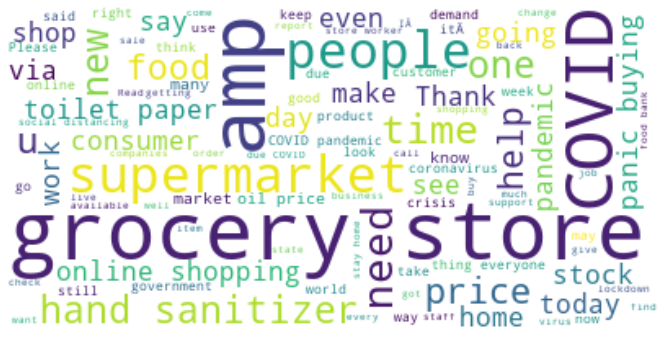

In [14]:

sequence = " ".join(review for review in text)
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(sequence)
fig = plt.figure(figsize = (20, 6)) 
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

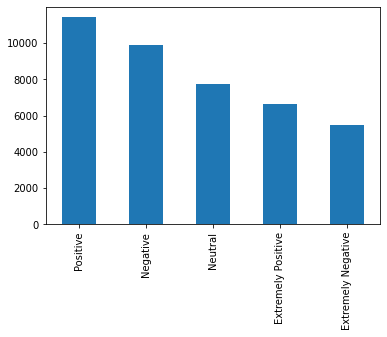

In [15]:
train_df.Sentiment.value_counts().plot(kind='bar')

In [17]:
X = text
y = labels
X, y = shuffle(X,y)

In [18]:
from sklearn.model_selection import train_test_split


In [19]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify = None)

In [20]:
from sklearn.feature_extraction.text import CountVectorizer


In [21]:
from sklearn.naive_bayes import MultinomialNB

vectorizer = CountVectorizer()
NB_ = MultinomialNB()
NB_.fit(vectorizer.fit_transform(X_train), y_train)


MultinomialNB()

In [23]:
prediction = NB_.predict(vectorizer.transform(X_train))


In [24]:
print(confusion_matrix(y_train, prediction))


[[10484   197  1594]
 [ 1225  3003  1956]
 [ 1340   196 12930]]


In [25]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('Analise')
    plt.xlabel('Predições');

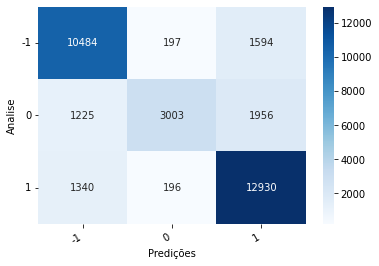

In [27]:
cm_NB = confusion_matrix(y_train, prediction)
df_NB = pd.DataFrame(cm_NB, index=np.unique(y_val), columns=np.unique(y_val))
show_confusion_matrix(df_NB)

In [28]:
print(classification_report(y_train, prediction))

              precision    recall  f1-score   support

          -1       0.80      0.85      0.83     12275
           0       0.88      0.49      0.63      6184
           1       0.78      0.89      0.84     14466

    accuracy                           0.80     32925
   macro avg       0.82      0.74      0.76     32925
weighted avg       0.81      0.80      0.79     32925



In [30]:
scores = cross_val_score(NB_, vectorizer.fit_transform(X_val), y_val, cv=5)

print(scores)

print(scores.mean())

[0.64055859 0.65998786 0.64155529 0.65066829 0.65066829]
0.648687661427936


In [31]:
print("Naive Bayes Accuracy Score -> ",accuracy_score(prediction, y_train)*100)

Naive Bayes Accuracy Score ->  80.2338648443432


In [32]:
svclassifier = SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
svclassifier.fit(vectorizer.fit_transform(X_train), y_train)


SVC(gamma='auto', kernel='linear')

In [33]:
pred_svm_test = svclassifier.predict(vectorizer.transform(X_val))


In [34]:
print(classification_report(y_val, pred_svm_test))


              precision    recall  f1-score   support

          -1       0.82      0.82      0.82      3123
           0       0.73      0.80      0.76      1529
           1       0.88      0.83      0.85      3580

    accuracy                           0.82      8232
   macro avg       0.81      0.82      0.81      8232
weighted avg       0.83      0.82      0.82      8232



In [39]:
scores = cross_val_score(svclassifier, vectorizer.fit_transform(X_val), y_val, cv=5)

print(scores)

print(scores.mean())

[0.71220401 0.70309654 0.70959903 0.70959903 0.69866343]
0.7066324057659237


In [35]:
print("SVM Accuracy Score -> ",accuracy_score(pred_svm_test, y_val)*100)

SVM Accuracy Score ->  82.26433430515063


In [36]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('Analise')
    plt.xlabel('Predições');

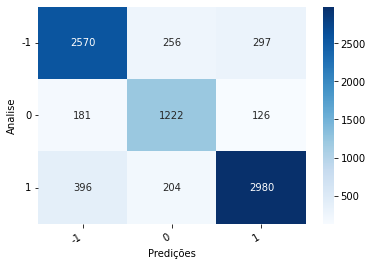

In [37]:
cm = confusion_matrix(y_val, pred_svm_test)
df_cm = pd.DataFrame(cm, index=np.unique(y_val), columns=np.unique(y_val))
show_confusion_matrix(df_cm)